<a href="https://colab.research.google.com/github/iguerrasevillano/TFM/blob/main/TLDR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [135]:
pip install xmltodict
pip install rouge_score

In [136]:
import xml.etree.ElementTree as ET
import xmltodict
import json

# Specify the path to your XML file
xml_file_path = path + 'W99-0629.xml'

# Parse the XML file
tree = ET.parse(xml_file_path)

# Get the root element
root = tree.getroot()

xml_string = ET.tostring(root, encoding="utf-8").decode("utf-8")



data_dict = xmltodict.parse(xml_string)

# Convert the dictionary to a JSON string
json_string = json.dumps(data_dict, indent=2)

# Print or use the resulting JSON string


NameError: name 'path' is not defined

### Libraries

In [1]:
!pip install datasets
!pip install rouge_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=c52a6ce08e5ff17ec31036888bd2749c88925091150b0096c506239b3e293045
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [1]:
# Libraries
import os
import pandas as pd
import numpy as np
import json

# Visualization
import matplotlib.pyplot as plt

# sklearn
from sklearn.model_selection import train_test_split

# Keras
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from transformers.keras_callbacks import KerasMetricCallback

# Transformers
from datasets import Dataset, DatasetDict, load_metric
from transformers import TFBartForConditionalGeneration, BartTokenizer, pipeline
from transformers import TFAutoModelForSeq2SeqLM, DataCollatorForSeq2Seq
from transformers import AdamWeightDecay

# NLTK
import nltk
nltk.download('punkt')

# Metrics
metric = load_metric('rouge')

# Current directory
os.getcwd()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
<ipython-input-1-6dc0a4d42110>:30: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric('rouge')
/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


'/content'

In [2]:
!pip install --upgrade tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 8.9 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: google-auth-oauthlib 0.4.6
    Uninstalling google-auth-oauthlib-0.4.6:
      Successfully uninstalled google-auth-oauthlib-0.4.6
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.12.0
    Uninstalling tenso

In [2]:
import tensorflow as tf
print(tf.__version__)

2.15.0


### Load and clean raw data

In [2]:
# Connect w/ Google Drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
BASE_PATH = "/content/drive/MyDrive/VIU/TFM/Desarrollo/Data/"

documents = os.listdir(BASE_PATH)

In [4]:
# AUXILIAR FUNCTIONS

def load_data(data):

  jsonl_file_path = BASE_PATH + 'TLDR/' + data + '.jsonl'

  # Read the JSON Lines file into a list of dictionaries
  data_list = []
  with open(jsonl_file_path, 'r') as jsonl_file:
      for line in jsonl_file:
          data_dict = json.loads(line)
          data_list.append(data_dict)

  return data_list



def metric_fn(eval_predictions):
  predictions, labels = eval_predictions
  decoded_predictions = tokenizer.batch_decode(predictions, skip_special_tokens=True)
  for label in labels:
      label[label < 0] = tokenizer.pad_token_id  # Replace masked label tokens
  decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
  # Rouge expects a newline after each sentence
  decoded_predictions = [
      "\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_predictions
  ]
  decoded_labels = [
      "\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels
  ]
  result = metric.compute(
      predictions=decoded_predictions, references=decoded_labels, use_stemmer=True
  )
  # Extract a few results
  result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
  # Add mean generated length
  prediction_lens = [
      np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions
  ]
  result["gen_len"] = np.mean(prediction_lens)

  return result

In [5]:
data_list = load_data('train')
data_list.extend(load_data('dev'))
data_list.extend(load_data('test'))

# Convert the list of dictionaries to a Pandas DataFrame
data = pd.DataFrame(data_list)

# Display the DataFrame
display(data.head())

,source,source_labels,rouge_scores,paper_id,target,title
0,[Due to the success of deep learning to solvin...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.3018867874688502, 0.37209301838831804, 0.60...",SysEexbRb,[We provide necessary and sufficient analytica...,NaN
1,[The backpropagation (BP) algorithm is often t...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.13043477920604923, 0.142857139229...",SygvZ209F7,"[Biologically plausible learning algorithms, p...",NaN
2,"[We introduce the 2-simplicial Transformer, an...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.33333332839506175, 0.8888888839111112, 0.11...",rkecJ6VFvr,[We introduce the 2-simplicial Transformer and...,NaN
3,"[We present Tensor-Train RNN (TT-RNN), a novel...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.06666666222222252, 0.06451612466181092, 0.0...",HJJ0w--0W,[Accurate forecasting over very long time hori...,NaN
4,[Recent efforts on combining deep models with ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.2777777727932099, 0.5714285666581633, 0.095...",HyH9lbZAW,[We propose a variational message-passing algo...,NaN


In [307]:
################
data = data[:100]
data.shape

(100, 6)

In [6]:
# Join all the sentences of source and target
def clean_data(data, column):
  data[column] = data[column].apply(lambda x : ' '.join(x))
  return data

data = clean_data(data, 'source')
data = clean_data(data, 'target')

# Drop columns
no_need_columns = ['source_labels', 'rouge_scores']
data = data.drop(columns=no_need_columns)

In [7]:
# Count number of words of source and target
def count_words(column):
  return data[column].apply(lambda x : len(x.split()))

data['number_words_target'] = count_words('target')
data['number_words_source'] = count_words('source')

In [8]:
print(data['number_words_target'].describe())
print(data['number_words_source'].describe())

count    3229.000000
mean       34.522453
std        24.459065
min         3.000000
25%        16.000000
50%        24.000000
75%        51.000000
max       149.000000
Name: number_words_target, dtype: float64
count     3229.000000
mean      4981.847011
std       2177.307224
min         37.000000
25%       3872.000000
50%       4870.000000
75%       6071.000000
max      25303.000000
Name: number_words_source, dtype: float64


In [9]:
# Summaries with less than 25 words are eliminated from the data
clean_data = data[data['number_words_target']>=25]
clean_data = clean_data.reset_index(drop=True)

In [10]:
clean_data['number_words_target'].mean()

53.068450528935905

In [11]:
print(clean_data.describe())

       number_words_target  number_words_source
count          1607.000000          1607.000000
mean             53.068451          5144.734287
std              22.211012          2190.799679
min              25.000000           120.000000
25%              32.000000          4018.500000
50%              51.000000          4999.000000
75%              69.500000          6173.500000
max             149.000000         25303.000000


### BART



In [12]:
# Split data in different sets
data_training, data_test = train_test_split(clean_data,
                                      test_size=0.20,
                                      random_state=42)

data_train, data_val = train_test_split(data_training,
                                        test_size=0.20,
                                        random_state=42)

In [13]:
print(data_train.shape, data_val.shape, data_training.shape, data_test.shape)

(1028, 6) (257, 6) (1285, 6) (322, 6)


In [14]:
# Convert all data to HF DatasetDict
tf_data_train = Dataset.from_pandas(data_train)
tf_data_test = Dataset.from_pandas(data_test)
tf_data_val = Dataset.from_pandas(data_val)

raw_data = DatasetDict({'train': tf_data_train,
                           'validation': tf_data_val,
                           'test': tf_data_test})

In [15]:
# Load BART Base-Model + Tokenizer
tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")
model = TFAutoModelForSeq2SeqLM.from_pretrained('facebook/bart-base')

model.generation_config.max_new_tokens = 40

model.config.attention_dropout = 0.3

print(model.config)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBartForConditionalGeneration.

All the weights of TFBartForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBartForConditionalGeneration for predictions without further training.


BartConfig {
  "_name_or_path": "facebook/bart-base",
  "activation_dropout": 0.1,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "BartModel"
  ],
  "attention_dropout": 0.3,
  "bos_token_id": 0,
  "classif_dropout": 0.1,
  "classifier_dropout": 0.0,
  "d_model": 768,
  "decoder_attention_heads": 12,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "early_stopping": true,
  "encoder_attention_heads": 12,
  "encoder_ffn_dim": 3072,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_token_id": 2,
  "forced_bos_token_id": 0,
  "forced_eos_token_id": 2,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_position_embeddings": 1024,
  "model_ty

In [16]:
# Function in order to tokenize source and target
max_input_length = 1024

def tokenize_function(data):
  model_inputs = tokenizer(data['source'], max_length=max_input_length, truncation=True, padding=True)

  with tokenizer.as_target_tokenizer():
    labels = tokenizer(data['target'], padding=True)

  # The target input_ids tokens are added to the model inputs
  model_inputs['labels'] = labels['input_ids']
  return model_inputs

In [17]:
# Tokenize data
tokenized_data = raw_data.map(tokenize_function, batched=True)

Map:   0%|          | 0/1028 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3856: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/257 [00:00<?, ? examples/s]

Map:   0%|          | 0/322 [00:00<?, ? examples/s]

In [18]:
tokenized_data

DatasetDict({
    train: Dataset({
        features: ['source', 'paper_id', 'target', 'title', 'number_words_target', 'number_words_source', '__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1028
    })
    validation: Dataset({
        features: ['source', 'paper_id', 'target', 'title', 'number_words_target', 'number_words_source', '__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 257
    })
    test: Dataset({
        features: ['source', 'paper_id', 'target', 'title', 'number_words_target', 'number_words_source', '__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 322
    })
})

In [19]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="np")

generation_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="np")

In [20]:
batch_size = 4
learning_rate = 2e-5
weight_decay = 0.01
num_train_epochs = 1

In [29]:
train_dataset

<_PrefetchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 1024), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 1024), dtype=tf.int64, name=None), 'decoder_input_ids': TensorSpec(shape=(None, 182), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 182), dtype=tf.int64, name=None))>

In [21]:
train_dataset = model.prepare_tf_dataset(
    tokenized_data['train'],
    batch_size=batch_size,
    shuffle=False,
    collate_fn=data_collator,
    drop_remainder=False
)

validation_dataset = model.prepare_tf_dataset(
    tokenized_data['validation'],
    batch_size=batch_size,
    shuffle=False,
    collate_fn=data_collator
)

generation_dataset = model.prepare_tf_dataset(
    tokenized_data['validation'],
    batch_size=8,
    shuffle=False,
    collate_fn=generation_data_collator
)

In [45]:
# Iterate through the dataset to inspect the batches
for batch in train_dataset.take(2):  # Take the first batch for inspection
    print(batch)

({'input_ids': <tf.Tensor: shape=(4, 1024), dtype=int64, numpy=
array([[    0,   133, 40363, ...,  1380, 24072,     2],
       [    0, 42489, 30464, ...,    52,    64,     2],
       [    0,   250,  3924, ...,    12, 24501,     2],
       [    0,   170,  6581, ..., 24176, 25083,     2]])>, 'attention_mask': <tf.Tensor: shape=(4, 1024), dtype=int64, numpy=
array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])>, 'decoder_input_ids': <tf.Tensor: shape=(4, 182), dtype=int64, numpy=
array([[    2,     0,   250, 14569,  7208,    13,  5516,  2937,     8,
         3228,    12, 45025,  2239,   634, 15029,     9,  7241, 18057,
        29659,   268,    19,  3685,    12, 14175,     8,  1373, 23341,
            4,  1698, 38395,    10, 14569,  7208,    13,   253,    12,
          560,    12,  1397,  2937,  2239,  1589, 11170, 14082,    19,
         1844, 26739,  4836,     4,  1437,   152,  2225, 21037,    10,
         1421,  

In [23]:
# Compile model
optimizer = AdamWeightDecay(
    learning_rate=learning_rate, weight_decay_rate=weight_decay
)

model.compile(optimizer=optimizer)

model.summary()

Model: "tf_bart_for_conditional_generation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (TFBartMainLayer)     multiple                  139420416 
                                                                 
 final_logits_bias (BiasLay  multiple                  50265     
 er)                                                             
                                                                 
Total params: 139470681 (532.04 MB)
Trainable params: 139420416 (531.85 MB)
Non-trainable params: 50265 (196.35 KB)
_________________________________________________________________


In [24]:
BART_PATH = BASE_PATH + '/Desarrollo/Results/TLDR/BART'
tensorboard_callback = TensorBoard(log_dir=BART_PATH+'/BART_model_save/logs')

metric_callback = KerasMetricCallback(
    metric_fn, eval_dataset=generation_dataset, predict_with_generate=True
)

callbacks = [metric_callback]

# Train
print('[INFO: fine-tuning model...]')
H = model.fit(train_dataset, validation_data=validation_dataset, epochs=8, callbacks=callbacks)

[INFO: fine-tuning model...]
Epoch 1/8
250/257 [============================>.] - ETA: 38s - loss: 3.2923

InvalidArgumentError: Graph execution error:

Detected at node EnsureShape_3 defined at (most recent call last):
<stack traces unavailable>
Shape of tensor args_1 [4,128] is not compatible with expected shape [?,182].
	 [[{{node EnsureShape_3}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_42934]

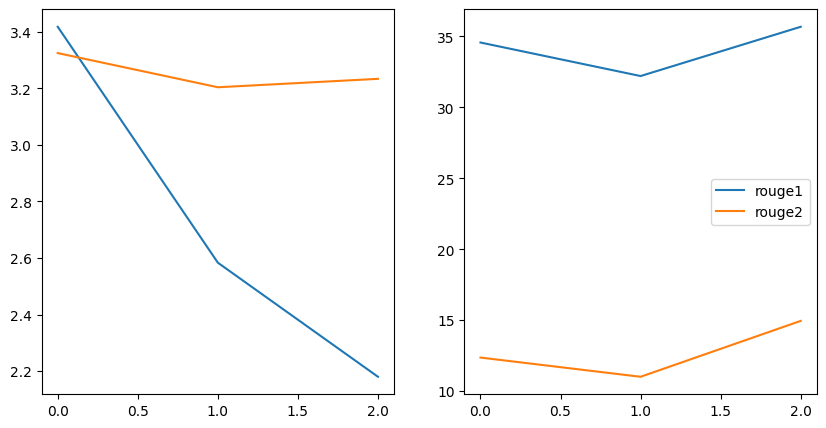

In [290]:
def plot_graphics(H):

    # Create a figure with 1 row and 2 columns, and set the figure size
    fig, ax = plt.subplots(1,2,figsize=(10,5))

    # Plot the training and validation loss for each epoch in the first subplot
    ax[0].plot(np.arange(0,len(H.history["loss"]) ), H.history["loss"], label="loss")
    ax[0].plot(np.arange(0,len(H.history["loss"])), H.history["val_loss"], label="val_loss")
    ax[1].plot(np.arange(0,len(H.history["loss"])), H.history["rouge1"], label="rouge1")
    ax[1].plot(np.arange(0,len(H.history["loss"])), H.history["rouge2"], label="rouge2")
    plt.legend()

plot_graphics(H)

In [291]:
print('[INFO]: generating tests summaries...')
generated_ids = model.generate(tokenized_data['test']['input_ids'])
tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

[INFO]: generating tests summaries...


'In this paper, we provide a necessary and sufficient characterization of the analytical forms for the critical points (as well as global minimizers) of the square loss functions for linear neural networks.'

In [292]:
# Fine-tuned model Test
predicted_labels = np.array(generated_ids)
reference_labels = np.array(tokenized_data['test']['labels'])

metric_fn((predicted_labels, reference_labels))

{'rouge1': 48.88888888888889,
 'rouge2': 35.82007527502475,
 'rougeL': 40.317460317460316,
 'rougeLsum': 41.46560846560846,
 'gen_len': 38.0}

In [293]:
# Pretrained model Test (check how results have improved)
pretrained_model = TFAutoModelForSeq2SeqLM.from_pretrained('facebook/bart-base')

pretrained_model.generation_config.max_new_tokens = model.generation_config.max_new_tokens

pretrained_generated_ids = pretrained_model.generate(tokenized_data['test']['input_ids'])
pretrained_predicted_labels = np.array(pretrained_generated_ids)

metric_fn((pretrained_predicted_labels, reference_labels))

All PyTorch model weights were used when initializing TFBartForConditionalGeneration.

All the weights of TFBartForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBartForConditionalGeneration for predictions without further training.


{'rouge1': 42.30484888019135,
 'rouge2': 28.21004209367174,
 'rougeL': 35.07139233166631,
 'rougeLsum': 35.70631296658694,
 'gen_len': 41.0}

In [328]:
i = 1
print('ORIGINAL:' + tokenized_data['test']['target'][i])
print('FINE TUNED MODEL:' + tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[i])
print('PRETRAINED MODEL:' + tokenizer.batch_decode(pretrained_generated_ids, skip_special_tokens=True)[i])

ORIGINAL:Adaptation of an RL agent in a target environment with unknown dynamics is fast and safe when we transfer prior experience in a variety of environments and then select risk-averse actions during adaptation.
FINE TUNED MODEL:We study the problem of safe adaptation: given a model trained on a variety of past experiences for some task, can this model learn to perform that task in a new situation while avoiding catastrophic failure
PRETRAINED MODEL:We study the problem of safe adaptation: given a model trained on a variety of past experiences for some task, can this model learn to perform that task in a new situation while avoiding catastrophic failure


In [327]:
tokenizer.model_max_length

1024